# Classification Problem 

## Load data

In [156]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics as met
from imblearn.metrics import classification_report_imbalanced
from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import pipeline as pl
from imblearn.combine import SMOTEENN
import scikitplot as skplt
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

In [157]:
train = pd.read_json('train.json')
train.shape

(391282, 20)

In [158]:
test = pd.read_json('test.json') # 20% 
test.shape

(97405, 19)

In [159]:
train.columns

Index(['agep', 'cit', 'dear', 'deye', 'esr', 'hicov', 'id', 'intp', 'mar',
       'pap', 'pincp', 'povpip', 'puma', 'race', 'retp', 'schl', 'sex', 'st',
       'vet', 'wkhp'],
      dtype='object')

### EDA

In [160]:
train.head(n=4)

,agep,cit,dear,deye,esr,hicov,id,intp,mar,pap,pincp,povpip,puma,race,retp,schl,sex,st,vet,wkhp
0,75,Citizen,No,No,Not in labor force,With Healthcare,2,0.0,Married,0.0,34000.0,376.0,10702,Two or more,24000.0,HS Degree,Male,6,Veteran,NaN
1,50,Citizen,No,No,Employed,With Healthcare,3,0.0,Married,0.0,14300.0,222.0,6514,Two or more,0.0,HS Degree,Female,6,Not Veteran,15.0
2,49,Citizen,No,No,Employed,With Healthcare,4,0.0,Married,0.0,15700.0,222.0,6514,White alone,0.0,HS Degree,Male,6,Not Veteran,35.0
3,28,Citizen,No,No,Employed,With Healthcare,6,0.0,Married,0.0,94000.0,501.0,3759,White alone,0.0,Undergrad. Degree,Female,6,Not Veteran,40.0


In [161]:
test.head(n=4)

,agep,cit,dear,deye,esr,id,intp,mar,pap,pincp,povpip,puma,race,retp,schl,sex,st,vet,wkhp
0,68,Citizen,No,No,Not in labor force,1,0.0,Married,0.0,20000.0,376.0,10702,Two or more,0.0,HS Degree,Female,6,Not Veteran,NaN
1,22,Citizen,No,No,Unemployed,5,0.0,Never Married,0.0,11500.0,222.0,6514,Two or more,0.0,HS Degree,Male,6,Not Veteran,12.0
2,32,Citizen,No,No,Not in labor force,9,84000.0,Married,0.0,84000.0,501.0,5917,White alone,0.0,Grad. Degree,Female,6,Not Veteran,NaN
3,42,Not citizen,Yes,No,Employed,22,0.0,Married,0.0,13000.0,145.0,10703,White alone,0.0,Less than HS,Male,6,Not Veteran,30.0


This is a imbalance classification problem: those without health care are only 6% of the training set. 

In [162]:
train['label'] = [1 if i== 'Without Healthcare' else 0 for i in train['hicov']]

In [163]:
# sns.barplot(y='label', data=train, ci=None);

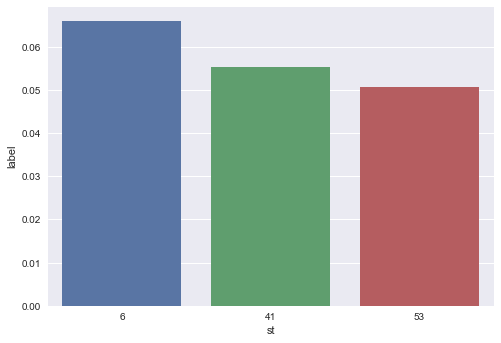

In [164]:
sns.barplot(y='label', x='st', ci=None,data=train);

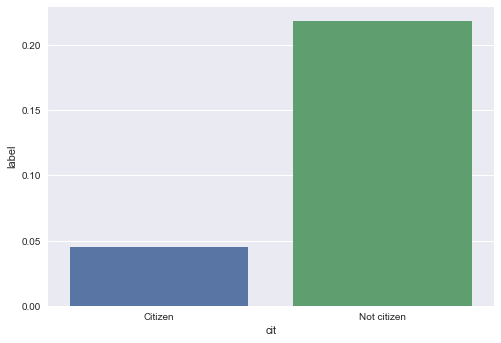

In [165]:
sns.barplot(y='label', x='cit', ci=None, data=train);

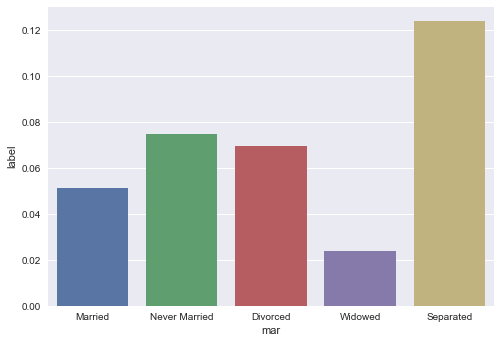

In [166]:
sns.barplot(y='label', x='mar', ci=None, data=train);

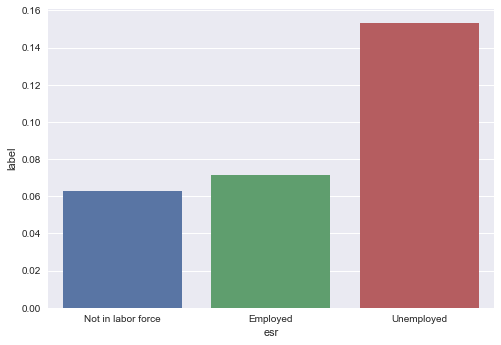

In [167]:
sns.barplot(y='label', x='esr', ci=None, data=train);

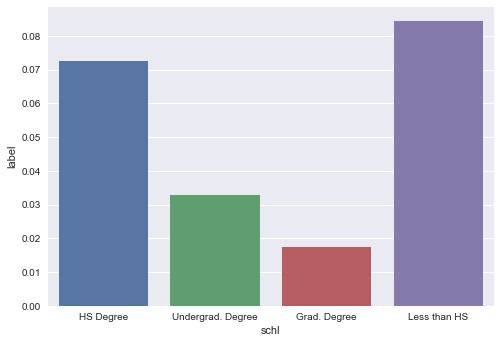

In [168]:
sns.barplot(y='label', x='schl', ci=None, data=train);

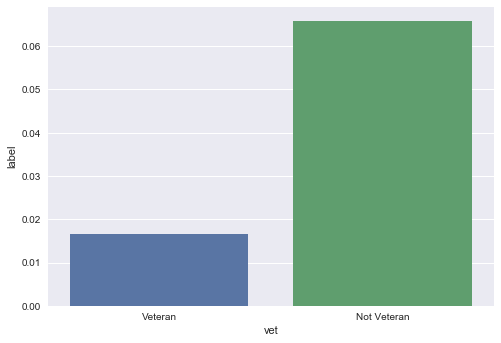

In [169]:
sns.barplot(y='label', x='vet', ci=None, data=train);

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

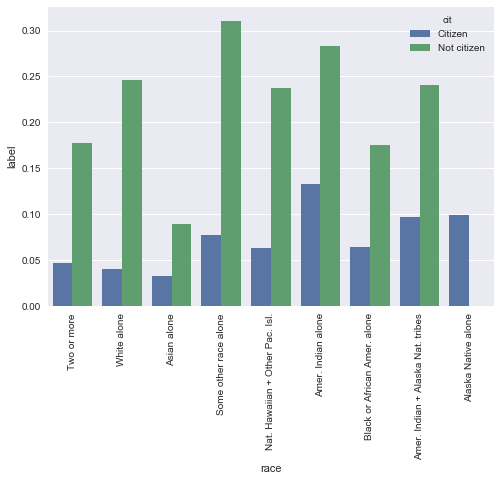

In [170]:
sns.barplot(y='label', x='race', hue='cit', ci=None, data=train);
plt.xticks(rotation='vertical')

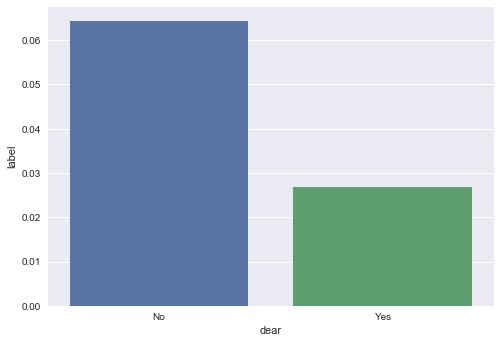

In [171]:
sns.barplot(y='label', x='dear', ci=None, data=train);

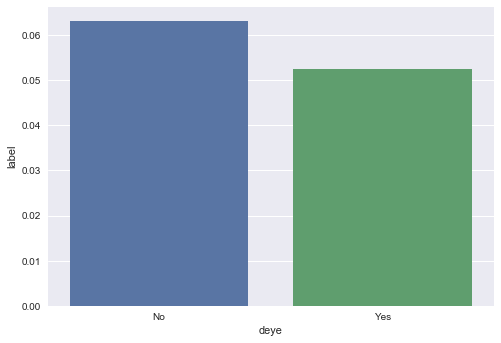

In [172]:
sns.barplot(y='label', x='deye', ci=None, data=train);

In [173]:
def log_with_zeros(values):
    return [np.log(i) if i >0.0 else np.log(0.01) for i in values]

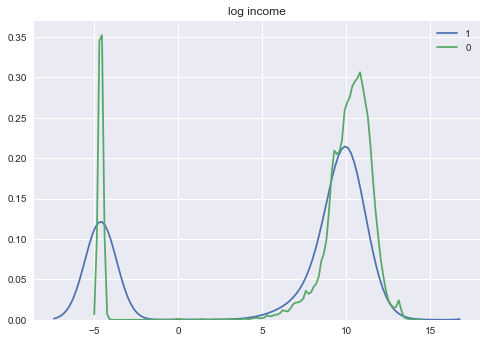

In [174]:
sns.kdeplot(log_with_zeros(train.loc[(train.label==1) & (train.pincp.notnull()), 'pincp']), label='1')
sns.kdeplot(log_with_zeros(train.loc[(train.label==0) & (train.pincp.notnull()), 'pincp']), label='0')
plt.title('log income');

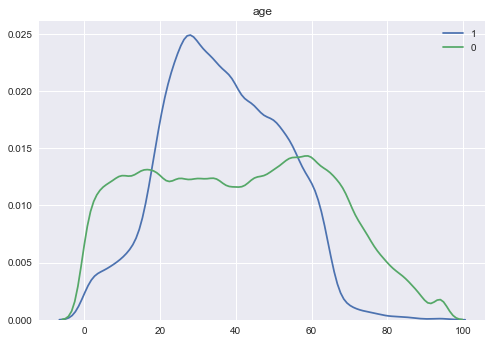

In [175]:
sns.kdeplot(train.loc[(train.label==1) & (train.agep.notnull()), 'agep'], label='1')
sns.kdeplot(train.loc[(train.label==0) & (train.agep.notnull()), 'agep'], label='0')
plt.title('age');

In [176]:
# recode age
train.loc[train.agep.isin(list(range(0,20))), 'age'] = '16-20'
train.loc[train.agep.isin(list(range(20,30))), 'age'] ='20-30'
train.loc[train.agep.isin(list(range(30,40))), 'age'] = '30-40'
train.loc[train.agep.isin(list(range(40,50))), 'age'] = '40-50'
train.loc[train.agep.isin(list(range(50,60))), 'age'] = '50-60'
train.loc[train.agep.isin(list(range(60,100))), 'age'] = '60+'

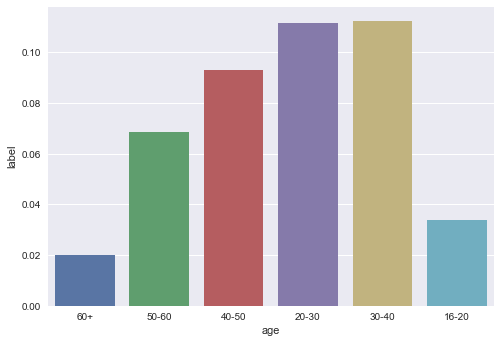

In [177]:
sns.barplot(y='label', x='age', ci=None, data=train);

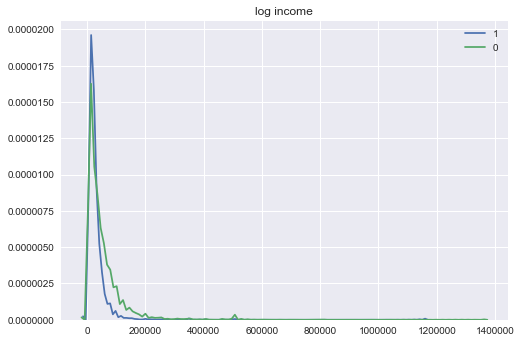

In [178]:
sns.kdeplot(train.loc[(train.label==1) & (train.pincp.notnull()), 'pincp'], label='1')
sns.kdeplot(train.loc[(train.label==0) & (train.pincp.notnull()), 'pincp'], label='0')
plt.title('log income');

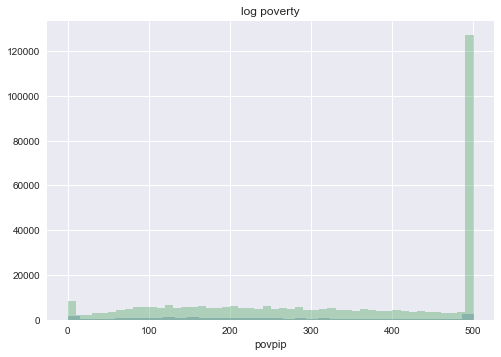

In [179]:
sns.distplot(train.loc[(train.label==1) & (train.povpip.notnull()), 'povpip'], label='1', kde=False)
sns.distplot(train.loc[(train.label==0) & (train.povpip.notnull()), 'povpip'], label='0', kde=False)
plt.title('log poverty');

In [180]:
# recode poverty ratio
train['pov'] = [1 if i<=100.0 else 0 for i in train['povpip']]

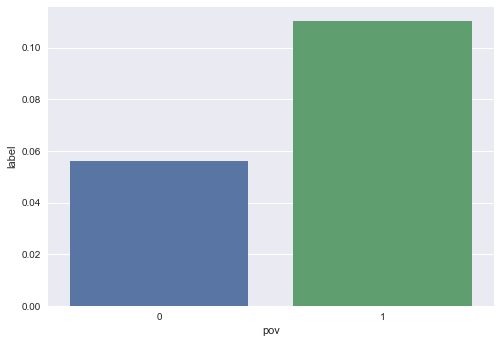

In [181]:
sns.barplot(y='label', x='pov', ci=None, data=train);

The poverty ratio is a truncated variable (at 501), I would just dichotomize that variable. 

### Missing data

In [182]:
def missing_data(df): 
    m = df.isnull().sum()/len(df)
    return m[m>0.00].sort_values(ascending=False)

In [183]:
missing_data(train)

wkhp      0.488292
esr       0.183604
retp      0.171086
pincp     0.171086
pap       0.171086
intp      0.171086
povpip    0.033454
schl      0.030592
dtype: float64

In [184]:
missing_data(test)

wkhp      0.486423
esr       0.183492
retp      0.171172
pincp     0.171172
pap       0.171172
intp      0.171172
povpip    0.033386
schl      0.030204
dtype: float64

Working hours might be related to workging status, so if person isn't working I can impute 0 hours.

In [185]:
pd.crosstab(train['esr'], train['wkhp'].isnull())

wkhp,False,True
esr,,
Employed,180553,0
Not in labor force,13645,113751
Unemployed,6024,5468


In [186]:
pd.crosstab(test['esr'], test['wkhp'].isnull())

wkhp,False,True
esr,,
Employed,45174,0
Not in labor force,3365,28178
Unemployed,1486,1329


It makes sense, most of the people not working hast missing working hours. 

In [187]:
# impute working hours
not_working = ['Not in labor force', 'Unemployed']
train.loc[train.esr.isin(not_working) & train.wkhp.isnull(), 'wkhp'] = 0.0
test.loc[test.esr.isin(not_working) & test.wkhp.isnull(), 'wkhp'] = 0.0

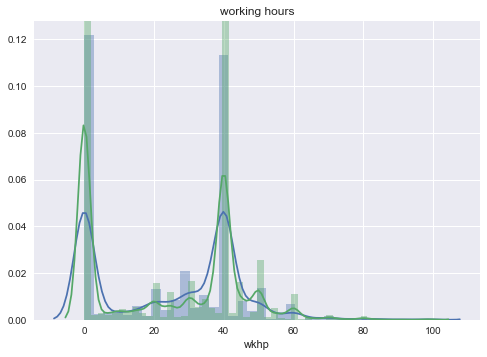

In [188]:
sns.distplot(train.loc[(train.label==1) & (train.wkhp.notnull()), 'wkhp'], label='1')
sns.distplot(train.loc[(train.label==0) & (train.wkhp.notnull()), 'wkhp'], label='0')
plt.title('working hours');

In [189]:
# recode groups
train.loc[train.wkhp==0, 'whours'] = 'not working'
train.loc[(train.wkhp>0) & (train.wkhp<21), 'whours'] = 'part-time'
train.loc[train.wkhp>=21, 'whours'] = 'full-time'

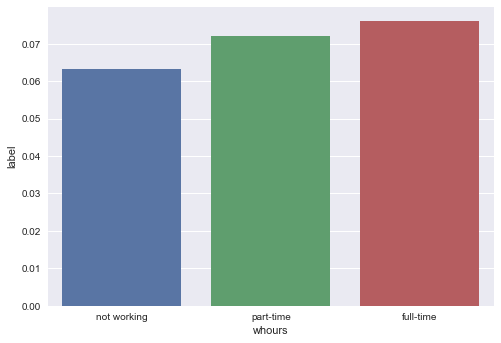

In [190]:
sns.barplot(y='label', x='whours', ci=None, data=train);

In [191]:
pd.crosstab(train['whours'], train['esr']).apply(lambda r: r/r.sum(), axis=0)

esr,Employed,Not in labor force,Unemployed
whours,,,
full-time,0.885845,0.062412,0.388792
not working,0.000000,0.892893,0.475809
part-time,0.114155,0.044695,0.135399


In [192]:
# missing data by class
train['missing'] = train.isnull().any(axis=1)
pd.crosstab(train['missing'], train['hicov']).apply(lambda r: r/r.sum(), axis=0)

hicov,With Healthcare,Without Healthcare
missing,,
False,0.782543,0.844987
True,0.217457,0.155013


In [193]:
# geographic info
train.st.value_counts()

6     301146
53     57923
41     32213
Name: st, dtype: int64

In [194]:
# impute missing values based on sex, age and state

# impute values based on state median
# by_state = df.groupby(['statename'])

# # Write a function that imputes median
# def impute_median(series):
#     return series.fillna(series.median())

# # Impute age and assign to titanic['age']
# df.crime_rate = by_state['crime_rate'].transform(impute_median)
# df.exercise = by_state['exercise'].transform(impute_median)
# df.smoking = by_state['smoking'].transform(impute_median)
# df.obesity = by_state['obesity'].transform(impute_median)


def impute_values(data, group_vars):  
    df = data.copy()
    group= df.groupby(group_vars)
    
    def impute_median(series):
        return series.fillna(series.median())
    
    def impute_mode(series):
        return series.fillna(series.mode()[0])

    # get variables with missing values

    m = df.isnull().sum()/len(df)
    variables = list(m[m>0.00].index)
    
    # impute 
    for v in variables:
        if (df[v].dtypes == np.dtype('int')) | (df[v].dtypes == np.dtype('float')):
            df[v] = group[v].transform(impute_median)
        elif (df[v].dtypes == np.dtype('object')):
            df[v] = group[v].transform(impute_mode) # most frequent category
    return df

In [195]:
# impute values
imp_train = impute_values(train, group_vars = ['st', 'sex', 'age'])
# listwise deletion
# imp_train = train.dropna()

In [196]:
train.loc[train['pincp'].isnull(), ['st', 'sex', 'age', 'id', 'pincp']].head()

,st,sex,age,id,pincp
11,6,Female,16-20,15,NaN
12,6,Female,16-20,16,NaN
19,6,Female,16-20,24,NaN
50,6,Male,16-20,60,NaN
55,6,Male,16-20,69,NaN


In [197]:
imp_train.loc[train['id'].isin([15, 16]), ['st', 'sex', 'age', 'id', 'pincp']]

,st,sex,age,id,pincp
11,6,Female,16-20,15,0.0
12,6,Female,16-20,16,0.0


In [198]:
# function to create dummy variable
def get_dummies(data, variables, drop_first=False):
    df = data.copy()
    dd = pd.DataFrame()
    for v in variables: 
        pd.get_dummies
        dd = pd.concat([dd, pd.get_dummies(df.loc[:,v], drop_first=drop_first, prefix=v)], axis=1)
    final = pd.concat([df.drop(variables, axis=1), dd], axis=1)
    final.columns = final.columns.str.replace('\+|\.|\s', '_').str.replace('_+', '_').str.lower()
    final.reset_index(inplace=True)
    return final

In [199]:
# create dummies
variables = ['cit', 'dear', 'deye', 'esr', 'mar', 
          'race', 'vet',  'schl', 'sex', 'puma', 'st', 'whours', 'pov'] 
clean_train = get_dummies(imp_train, variables, drop_first=True)

In [200]:
# check missing records
missing_data(clean_train)

Series([], dtype: float64)

In [201]:
clean_train.shape # 371 features

(391282, 377)

In [202]:
clean_train.label.value_counts() # imbalance classification

0    366684
1     24598
Name: label, dtype: int64

In [203]:
# reverse coding
# clean_labels = pd.Series([0 if i==1 else 1 for i in clean_train['hicov_without_healthcare']])
clean_labels = clean_train['label']

In [204]:
clean_labels.sum()

24598

In [205]:
clean_train.columns

Index(['index', 'agep', 'hicov', 'id', 'intp', 'pap', 'pincp', 'povpip',
       'retp', 'wkhp',
       ...
       'puma_11705', 'puma_11706', 'puma_11801', 'puma_11802', 'puma_11900',
       'st_41', 'st_53', 'whours_not_working', 'whours_part-time', 'pov_1'],
      dtype='object', length=377)

In [206]:
clean_train.drop(['id', 'index', 'missing', 'wkhp', 'age', 'label', 'hicov', 
                 'povpip'], axis=1, inplace=True)

In [207]:
clean_train.drop(clean_train.filter(regex='^puma_').columns.tolist(), axis=1, inplace=True)

In [208]:
missing_data(clean_train)

Series([], dtype: float64)

In [209]:
clean_train.head()

,agep,intp,pap,pincp,retp,cit_not_citizen,dear_yes,deye_yes,esr_not_in_labor_force,esr_unemployed,...,vet_veteran,schl_hs_degree,schl_less_than_hs,schl_undergrad_degree,sex_male,st_41,st_53,whours_not_working,whours_part-time,pov_1
0,75,0.0,0.0,34000.0,24000.0,0,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1,50,0.0,0.0,14300.0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,49,0.0,0.0,15700.0,0.0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,28,0.0,0.0,94000.0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,31,0.0,0.0,110000.0,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Create validation set

The training set has enough data to create a validation set

In [210]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [211]:
X_train, X_test, y_train, y_test = train_test_split(clean_train, clean_labels, test_size=0.20, 
                                                    random_state=123, stratify=clean_labels)

In [233]:
# cross validation function with over or under sampling
def cross_validate(estimator, n_splits, features, labels, 
                   random_state=123, bagging=True): 
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_count=0 # iteration index
    for train_index, val_index in skf.split(features, labels):
        fold_count+=1
        print("\n Processing fold %s" % fold_count)
        
        if bagging:
            estimator.fit(features.iloc[train_index], labels.iloc[train_index])
        else:
#             X_resampled, y_resampled = us.AllKNN(random_state=random_state).fit_sample(
#                 features.iloc[train_index],
#                 labels.iloc[train_index])
#             X_resampled, y_resampled = SMOTEENN(random_state=random_state).fit_sample(
#                 features.iloc[train_index],
#                 labels.iloc[train_index])
            X_resampled, y_resampled = os.ADASYN(random_state=random_state).fit_sample(
                features.iloc[train_index],
                labels.iloc[train_index])
            estimator.fit(X_resampled, y_resampled)
            
        pred = estimator.predict(features.iloc[val_index])
#         pred = [1 if i[1]>0.50 else 0 for i in pred_proba]
        # plots
#         skplt.metrics.plot_precision_recall_curve(labels.iloc[val_index], pred_proba)
#         skplt.metrics.plot_roc_curve(labels.iloc[val_index], pred_proba)
        # evaluation 
        print('\n Classification report:\n')
        print(classification_report_imbalanced(labels.iloc[val_index], pred))
        print('Confusion matrix:\n')
        print(met.confusion_matrix(labels.iloc[val_index], pred))

### Baseline

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [219]:
log_reg = LogisticRegression()

In [220]:
cross_validate(log_reg, n_splits=3, features=X_train, labels=y_train, bagging=False)


 Processing fold 1

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.41      0.74      0.58      0.27      0.08     97783
          1       0.08      0.74      0.41      0.14      0.27      0.07      6560

avg / total       0.90      0.43      0.72      0.55      0.27      0.08    104343

Confusion matrix:

[[40281 57502]
 [ 1708  4852]]

 Processing fold 2

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.43      0.75      0.59      0.28      0.08     97782
          1       0.08      0.75      0.43      0.15      0.28      0.07      6559

avg / total       0.91      0.45      0.73      0.56      0.28      0.08    104341

Confusion matrix:

[[41699 56083]
 [ 1644  4915]]

 Processing fold 3

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

        

### Random Forest

In [221]:
from imblearn.ensemble import BalancedBaggingClassifier 
from  sklearn.ensemble import RandomForestClassifier

In [222]:
rnd_clf = RandomForestClassifier(n_estimators=100)

In [224]:
bbc = BalancedBaggingClassifier(base_estimator=rnd_clf, random_state=123)

In [225]:
cross_validate(bbc, n_splits=3, features=X_train, labels=y_train, bagging=True) # slow


 Processing fold 1

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.74      0.76      0.84      0.40      0.17     97783
          1       0.16      0.76      0.74      0.27      0.40      0.15      6560

avg / total       0.93      0.74      0.76      0.80      0.40      0.17    104343

Confusion matrix:

[[71972 25811]
 [ 1589  4971]]

 Processing fold 2

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.74      0.76      0.84      0.40      0.17     97782
          1       0.16      0.76      0.74      0.27      0.40      0.15      6559

avg / total       0.93      0.74      0.76      0.80      0.40      0.17    104341

Confusion matrix:

[[71940 25842]
 [ 1555  5004]]

 Processing fold 3

 Classification report:

                   pre       rec       spe        f1       geo       iba       sup

        

In [226]:
# cross_validate(rnd_clf, n_splits=3, features=X_train, labels=y_train, bagging=False)

### xgboost

In [227]:
import xgboost as xgb

In [234]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)

In [ ]:
cross_validate(xgb_clf, n_splits=3, features=X_train, labels=y_train, bagging=False) # slow


 Processing fold 1


# Feature importance

In [ ]:
# function to create feature importance plot
def importance_plot(estimator, features, thresold = 0.0):
    im = sorted(zip(map(lambda x: round(x, 3), estimator.feature_importances_), 
           features))
    im  = pd.DataFrame(im, columns=['importance', 'feature'])
    im = im.loc[im.importance > thresold,:] # filter
    plot = im.plot.barh(x='feature',legend=None)
    plt.ylabel('Features')
    plt.xlabel('Importance')
    return plot

In [ ]:
importance_plot(rnd_clf, features);

# Validation set

Test using the validation set created above.